In [1]:
import sys
sys.path.append('..')

import torch
import tiktoken
from src.model import GPTModel, replace_linear_with_lora
from src.finetune import train_model_simple, generate_text_simple, text_to_token_ids, token_ids_to_text, generate
from src.formatter import format_input_advanced
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from src.loader import load_weights_into_gpt, download_and_load_gpt2
from src.finetune import calc_loss_loader, train_model_simple, train_model_with_checkpoints

2025-10-28 11:08:33.480579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import json
import os
import urllib.request
import ssl
import certifi

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        # Create verified SSL context
        ssl_context = ssl.create_default_context(cafile=certifi.where())
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "../data/alpaca-instruction-data.json"
url = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 52002


In [3]:
print("Example entry:\n", data[0])

Example entry:
 {'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}


In [4]:
PROMPT_STYLE = 'enhanced'

def format_input(entry):
    """
    Format instruction using the advanced formatter module.
    
    Available styles:
    - 'enhanced': Improved Alpaca format (recommended)
    - 'chatml': ChatML-style format (ChatGPT/GPT-4 style)
    - 'task_aware': Adapts based on task type
    - 'cot': Chain-of-thought for reasoning tasks
    - 'structured': Encourages structured outputs
    """
    return format_input_advanced(entry, style=PROMPT_STYLE)

In [5]:
train_portion = int(len(data) * 0.85)    #1
test_portion = int(len(data) * 0.1)            #2
val_portion = len(data) - train_portion - test_portion    #3

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 44201
Validation set length: 2601
Test set length: 5200


In [6]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:         #1
            instruction_plus_input = format_input(entry)
            response_text = f"{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [8]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """Original collate function (kept for comparison)"""
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = (                               
            new_item + [pad_token_id] *          
            (batch_max_length - len(new_item))   
        )
        inputs = torch.tensor(padded[:-1])      
        targets = torch.tensor(padded[1:])     

        mask = targets == pad_token_id              
        indices = torch.nonzero(mask).squeeze()     
        if indices.numel() > 1:                     
            targets[indices[1:]] = ignore_index     

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]       
            targets = targets[:allowed_max_length]     

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():   #1
#     device = torch.device("mps")"      
print("Device:", device)

Device: cuda


In [10]:
from functools import partial

# Option 1: Use original collate function (compatible with existing code)
customized_collate_fn = partial(
    custom_collate_fn,  # Changed from custom_collate_fn_optimized
    device=device,
    allowed_max_length=1024
)

In [11]:
from torch.utils.data import DataLoader

num_workers = 0      #1
batch_size = 4

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [12]:
print("Train loader:")
# Complete information about your DataLoader
print(f"Batch size: {train_loader.batch_size}")
print(f"Total samples: {len(train_loader.dataset)}")
print(f"Samples per epoch: {len(train_loader.dataset)}")

Train loader:
Batch size: 4
Total samples: 44201
Samples per epoch: 44201


In [13]:
CHOOSE_MODEL = "gpt2-large (774M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,          #1
    "context_length": 1024,       #2
    "drop_rate": 0.1,             #3
    "qkv_bias": True              #4
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [14]:
import os

# Check if checkpoint file exists
checkpoint_path = "gpt2-large774M-sft3.pth"

if os.path.exists(checkpoint_path):
    print(f"✓ Found existing checkpoint: {checkpoint_path}")
    print("Loading model from checkpoint with LoRA...")
    
    # IMPORTANT: The checkpoint was saved from a LoRA-enabled model
    # So we need to create a model WITH LoRA structure first
    
    # Step 1: Create a base model
    model = GPTModel(BASE_CONFIG)
    
    # Step 2: Freeze base model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Step 3: Apply LoRA (MUST match the rank/alpha used during training!)
    # The checkpoint was saved with rank=16, alpha=16
    replace_linear_with_lora(model, rank=8, alpha=16)
    
    # Step 4: NOW load the checkpoint (which includes LoRA weights)
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint)
    
    # Step 5: Move to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    print("✓ Model loaded successfully from checkpoint!")
    print(f"Total trainable LoRA parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    print("Loading base GPT-2 model and applying LoRA...")
    
    # Download and load base GPT-2 model
    model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
    settings, params = download_and_load_gpt2(
        model_size=model_size, models_dir="gpt2"
    )
    
    # Create model and load pretrained weights
    model = GPTModel(BASE_CONFIG)
    load_weights_into_gpt(model, params)
    model.eval()
    
    # Freeze base model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Apply LoRA for fine-tuning
    replace_linear_with_lora(model, rank=8, alpha=16)
    
    # Move to device
    model = model.to(device)
    
    print("✓ Base model loaded with LoRA applied!")
    print(f"Total trainable LoRA parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

✗ Checkpoint not found: gpt2-large774M-sft3.pth
Loading base GPT-2 model and applying LoRA...
File already exists and is up-to-date: gpt2/774M/checkpoint


File already exists and is up-to-date: gpt2/774M/encoder.json
File already exists and is up-to-date: gpt2/774M/hparams.json
File already exists and is up-to-date: gpt2/774M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/774M/model.ckpt.index
File already exists and is up-to-date: gpt2/774M/model.ckpt.meta
File already exists and is up-to-date: gpt2/774M/vocab.bpe
✓ Base model loaded with LoRA applied!
Total trainable LoRA parameters: 7,047,816


In [15]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(INPUT_PROMPT, tokenizer).to(device),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)
print(generated_text)

Every effort moves us forward.

"We are not going to be satisfied until we have a team that is competitive in every game.


In [16]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader, model, device, num_batches=5
    
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)
print("Test loss:", test_loss)

Training loss: 3.1452971935272216
Validation loss: 3.3175879955291747
Test loss: 3.488521766662598


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=1280

In [18]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00002, weight_decay=0.01)

num_epochs = 3

train_losses, val_losses, tokens_seen = train_model_with_checkpoints(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer,
    checkpoint_dir="checkpoints",  # Directory to save checkpoints
    checkpoint_freq_steps=1000,     # Save checkpoint every 1000 steps
    keep_last_k=2,                  # Keep only the last 3 checkpoints
    auto_resume=True                # Automatically resume from latest checkpoint if available
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Auto-resume: using latest checkpoint checkpoints/oom_step10299.pt
Resuming from checkpoint: epoch 1, step 10299, batch 10303, tokens 6904832
Starting training: epochs 1 to 3, eval every 5 steps
Ep 1 (Step 010300): Train loss 1.151, Val loss 1.559
Ep 1 (Step 010305): Train loss 1.416, Val loss 1.557
Ep 1 (Step 010310): Train loss 1.275, Val loss 1.559
Ep 1 (Step 010315): Train loss 1.174, Val loss 1.558
Ep 1 (Step 010320): Train loss 1.092, Val loss 1.555
Ep 1 (Step 010325): Train loss 1.261, Val loss 1.552
Ep 1 (Step 010330): Train loss 1.315, Val loss 1.552
Ep 1 (Step 010335): Train loss 1.234, Val loss 1.553
Ep 1 (Step 010340): Train loss 1.243, Val loss 1.555
Ep 1 (Step 010345): Train loss 1.170, Val loss 1.554
Ep 1 (Step 010350): Train loss 1.216, Val loss 1.554
Ep 1 (Step 010355): Train loss 1.119, Val loss 1.556
Ep 1 (Step 010360): Train loss 1.245, Val loss 1.557
Ep 1 (Step 010365): Train loss 1.226, Val loss 1.557
Ep 1 (Step 010370): Train loss 1.162, Val loss 1.559
Ep 1 (Step 

In [19]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft3.pth"      #1
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-large774M-sft3.pth


In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                   #1
    ax2.plot(tokens_seen, train_losses, alpha=0)     #2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

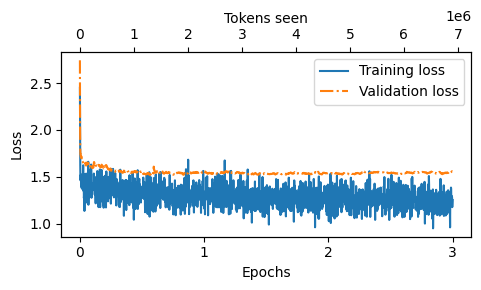

In [21]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [20]:
# Find your exact checkpoint file
import os
checkpoint_dir = "checkpoints"
checkpoints = [f for f in os.listdir(checkpoint_dir) if '10' in f]
print("Available 10K checkpoints:", checkpoints)

# Load the checkpoint (adjust filename based on what you find)
checkpoint_path = "checkpoints/ckpt_step10000.pt"  # or oom_step10299.pt

# Create model with same config
model_best = GPTModel(BASE_CONFIG)
for param in model_best.parameters():
    param.requires_grad = False
replace_linear_with_lora(model_best, rank=8, alpha=16)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# The checkpoint might have full state or just model_state_dict
if "model_state_dict" in checkpoint:
    model_best.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded from step: {checkpoint.get('global_step', 'unknown')}")
    print(f"Epoch: {checkpoint.get('epoch', 'unknown')}")
else:
    model_best.load_state_dict(checkpoint)

model_best = model_best.to(device)
model_best.eval()

print("✅ Best model loaded from Step 10K (Epoch 1)")

Available 10K checkpoints: ['oom_step10299.pt', 'ckpt_step1000.pt', 'ckpt_step10000.pt']
Loaded from step: 10000
Epoch: 0
✅ Best model loaded from Step 10K (Epoch 1)


In [21]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model_best, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model_best, device, num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader, model_best, device, num_batches=5
    
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)
print("Test loss:", test_loss)

Training loss: 1.191306734085083
Validation loss: 1.5327175378799438
Test loss: 1.2895723462104798


In [23]:
torch.manual_seed(123)

for entry in test_data[:1]:      #1
    input_text = format_input(entry)
    token_ids = generate(               #2
        model=model_best,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a famous movie with the input name
### Input:
Grace
### Response:


Correct response:
>> Grace Unplugged (2013)

Model response:
>> The Godfather
-------------------------------------


In [24]:
# Save as your final production model
final_model_name = "gpt2-large774M-sft-BEST.pth"
torch.save(model_best.state_dict(), final_model_name)
print(f"✅ Best model saved as: {final_model_name}")
print(f"   From: Step ~10K, End of Epoch 1")
print(f"   Val loss: ~1.54 (vs original 1.728)")
print(f"   Improvement: ~11% better generalization")

✅ Best model saved as: gpt2-large774M-sft-BEST.pth
   From: Step ~10K, End of Epoch 1
   Val loss: ~1.54 (vs original 1.728)
   Improvement: ~11% better generalization


In [26]:
import random
import json
from copy import deepcopy
from tqdm import tqdm

def save_random_test_records(test_data, num_records, seed, model, tokenizer, device, output_file="random_test_records.json"):
    """
    Selects random records from test_data, generates model responses, and saves them to a file 
    without modifying the original data.
    
    Args:
        test_data (list): The test dataset to sample from
        num_records (int): Number of random records to select
        seed (int): Random seed for reproducible selection
        model: The trained model for generating responses
        tokenizer: Tokenizer for text processing
        device: Device to run inference on
        output_file (str): Output file path to save the selected records with model responses
    
    Returns:
        list: The selected random records with model responses (copy of original data)
    """
    # Set the random seed for reproducible results
    random.seed(seed)
    
    # Create a deep copy to avoid modifying the original test_data
    test_data_copy = deepcopy(test_data)
    
    # Ensure we don't try to select more records than available
    num_records = min(num_records, len(test_data_copy))
    
    # Randomly sample records without replacement
    selected_records = random.sample(test_data_copy, num_records)
    
    print(f"Generating model responses for {len(selected_records)} selected records...")
    
    # Generate model responses for each selected record
    for i, entry in tqdm(enumerate(selected_records), total=len(selected_records)):
        # Create formatted input text
        input_text = format_input(entry)
        
        # Generate model response
        token_ids = generate(
            model=model,
            idx=text_to_token_ids(input_text, tokenizer).to(device),
            max_new_tokens=256,
            context_size=BASE_CONFIG["context_length"],  # Using the context length from BASE_CONFIG
            eos_id=50256
        )
        generated_text = token_ids_to_text(token_ids, tokenizer)
        
        # Extract the model response (remove the input prompt)
        response_text = (
            generated_text[len(input_text):]
            .replace("### Response:", "")
            .strip()
        )
        
        # Add the model response to the entry
        selected_records[i]["model_response"] = response_text
        
    
    # Save to file
    with open(output_file, "w", encoding="utf-8") as file:
        json.dump(selected_records, file, indent=4, ensure_ascii=False)
    
    print(f"Successfully saved {len(selected_records)} random records with model responses to '{output_file}'")
    print(f"Used seed: {seed}")
    
    return selected_records

In [27]:
selected_records = save_random_test_records(
    test_data, 
    num_records=50, 
    seed=42, 
    model=model_best, 
    tokenizer=tokenizer, 
    device=device, 
    output_file="my_random_test_with_responses.json"
)

Generating model responses for 50 selected records...


100%|██████████| 50/50 [03:20<00:00,  4.01s/it]

Successfully saved 50 random records with model responses to 'my_random_test_with_responses.json'
Used seed: 42


# 🚀 Improved Training Configuration

## Changes to Prevent Overfitting:

### ✅ Already Applied:
1. **Dropout enabled**: `drop_rate = 0.1` (prevents memorization)

### 🆕 New Improvements:
2. **Lower learning rate**: `5e-5 → 2e-5` (better generalization)
3. **Reduced weight decay**: `0.1 → 0.01` (less aggressive regularization)
4. **Gradient clipping**: `max_norm=1.0` (training stability)
5. **Learning rate scheduler**: Cosine annealing (gradual LR reduction)
6. **Early stopping**: Stop when validation loss plateaus
7. **Increased batch size**: `4 → 8` (more stable gradients, if GPU memory allows)

### Optional:
8. **Reduced LoRA rank**: `16 → 8` (less overfitting capacity)

---

## Why These Changes Help:

**Current Problem:** Training loss (1.008) << Validation loss (1.728) = **Overfitting**

**Solution:** These changes force the model to learn generalizable patterns instead of memorizing training data.


In [ ]:
# ========================================
# IMPROVED TRAINING CONFIGURATION
# ========================================

print("=" * 60)
print("🔧 IMPROVED TRAINING CONFIGURATION")
print("=" * 60)

# Hyperparameters comparison
config_comparison = {
    "Learning Rate": {"Old": "5e-5", "New": "2e-5", "Reason": "Better generalization"},
    "Weight Decay": {"Old": "0.1", "New": "0.01", "Reason": "Less aggressive regularization"},
    "Batch Size": {"Old": "4", "New": "8", "Reason": "More stable gradients"},
    "Dropout": {"Old": "0.0", "New": "0.1", "Reason": "Already enabled ✓"},
    "Gradient Clip": {"Old": "None", "New": "1.0", "Reason": "Training stability"},
    "LR Scheduler": {"Old": "None", "New": "Cosine", "Reason": "Gradual LR reduction"},
    "Early Stopping": {"Old": "None", "New": "3 epochs", "Reason": "Auto-optimization"},
}

for param, values in config_comparison.items():
    print(f"\n{param:15s}: {values['Old']:8s} → {values['New']:10s}")
    print(f"                └─ {values['Reason']}")

print("\n" + "=" * 60)
